# DEA Waterbodies: Collection 3

This notebook compares DEA Waterbodies Collection 2 and Collection 3 to see if there are any significant differences.

In [1]:
import sys
import warnings
from pathlib import Path

import datacube
import geopandas as gpd
import matplotlib
import numpy as np
import pandas as pd
import scipy.stats
from IPython.display import Image, display
from matplotlib import pyplot as plt
from scipy.stats import distributions
from tqdm.notebook import tqdm

sys.path.append("../Scripts")
from dea_bandindices import calculate_indices
from dea_datahandling import load_ard
from dea_plotting import rgb, xr_animation

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = (6, 4)

In [2]:
dc = datacube.Datacube(app="c3-waterbodies")

In [3]:
waterbodies_path = Path(
    "/g/data/r78/cek156/dea-notebooks/Scientific_workflows/DEAWaterbodies/C3/"
)
c2_25_path = waterbodies_path / "timeseries_aus_c2_25m"
c3_30_path = waterbodies_path / "timeseries_aus_c3_30m"

In [4]:
wbs = gpd.read_file(waterbodies_path / "Waterbodies_C3_subset.shp").set_index("UID")

In [113]:
wbs.to_crs('EPSG:4326').total_bounds

array([149.32574401, -29.80249366, 150.00427036, -29.4603343 ])

Ness also generated some statistics for these waterbodies, which we will also load.

In [6]:
stats_comp = pd.read_csv(waterbodies_path / "c2_c3_comparison_new.csv").set_index("UID")
stats_comp.columns = stats_comp.columns.str.strip()

## Plotting basic stats

Let's start by visualising Ness' statistics to see the difference between the two collections.

In [7]:
stat_names = {
    "mean wet pixel percentage": "{}_Wet_pixel_percentage_mean",
    "mean number of wet pixels": "{}_num_wet_pixels_mean",
    "total number of pixels": "{}_total_num_pix",
    "number of valid observations": "num_valid_obs_{}",
}

In [8]:
stat_columns = {
    stat_name: {fm: stat_col.format(fm) for fm in ["c2_25m", "c3_30m"]}
    for stat_name, stat_col in stat_names.items()
}

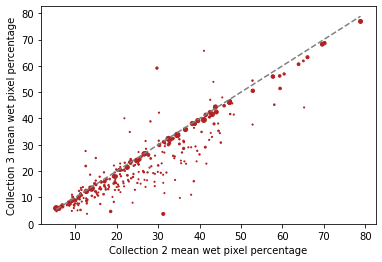

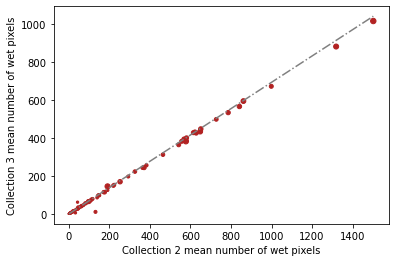

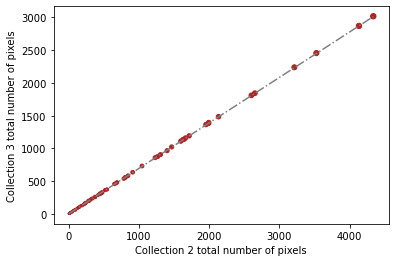

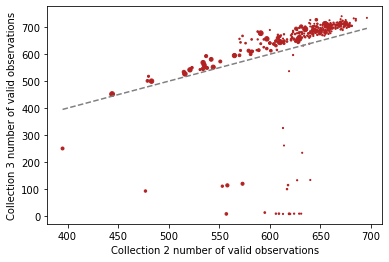

In [115]:
for name, cols in stat_columns.items():
    plt.figure()
    c2 = stats_comp[cols["c2_25m"]]
    c3_30 = stats_comp[cols["c3_30m"]]
    s = np.sqrt(stats_comp["c2_25m_total_num_pix"] / 5)
    plt.scatter(c2, c3_30, label="C3 30m", c="firebrick", s=s)
    min_, max_ = c2.min(), c2.max()
    if "num" in name and "pix" in name:
        plt.plot(
            [min_, max_],
            [min_ * (25 / 30) ** 2, max_ * (25 / 30) ** 2],
            c="grey",
            linestyle="-.",
        )
    else:
        plt.plot([min_, max_], [min_, max_], c="grey", linestyle="--")
    plt.xlabel(f"Collection 2 {name}")
    plt.ylabel(f"Collection 3 {name}")
    plt.show()

The number of pixels and mean number of wet pixels both line up pretty well. The mean wet pixel percentage lines up well too, but with a fair bit of scatter (this should be fine - I think it comes from the fact that the scatter in number-of-wet-pixels is low, and this is backed up by the fact that the percentage is more variable for smaller waterbodies).

Is the additional dryness in C3 significant? Let's test the deviation of the discrepancy from zero.

In [74]:
difference = stats_comp[stat_columns['mean wet pixel percentage']['c2_25m']] - stats_comp[stat_columns['mean wet pixel percentage']['c3_30m']]

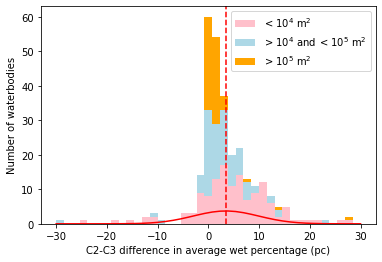

In [100]:
bins = np.linspace(-30, 30, 40)
loc_c2c3, scale_c2c3 = distributions.norm.fit(difference)
dist_c2c3 = distributions.norm(loc=loc_c2c3, scale=scale_c2c3)
# hist = plt.hist(difference, bins=bins, color="grey")
plt.plot(bins, dist_c2c3.pdf(bins) * 60, c="red")
hist = plt.hist([
    difference[wbs.area < 1e4],
    difference[(wbs.area > 1e4) & (wbs.area < 1e5)],
    difference[wbs.area > 1e5],
], bins=bins, color=['pink', 'lightblue', 'orange'], label=['$<10^4$ m$^2$', '$>10^4$ and $<10^5$ m$^2$', '$>10^5$ m$^2$'], histtype='barstacked')
plt.legend()
plt.axvline(np.nanmean(difference), c="red", linestyle="--")
plt.xlabel("C2-C3 difference in average wet percentage (pc)")
plt.ylabel("Number of waterbodies");

In [80]:
scipy.stats.ttest_1samp(difference, 0)

Ttest_1sampResult(statistic=9.067656234949341, pvalue=2.0587761161053713e-17)

This _is_ a significant difference. But we should also keep in mind that this is heavily affected by small waterbodies, which are given equal weighting in this test. Large waterbodies seem consistent.

C2 is significantly wetter than C3.

## Loading the CSVs

Now we'll load the full time series for each collection.

In [10]:
c2_25 = {}
for p in c2_25_path.iterdir():
    for q in p.iterdir():
        name = q.stem
        if not q.suffix == ".csv":
            continue
        c2_25[name] = pd.read_csv(q).set_index("Observation Date")
        c2_25[name].columns = ["pc_wet", "px_wet"]
        c2_25[name].index = pd.to_datetime(c2_25[name].index)

c3_30 = {}
for p in c3_30_path.iterdir():
    for q in p.iterdir():
        name = q.stem
        if not q.suffix == ".csv":
            continue
        c3_30[name] = pd.read_csv(q).set_index("Observation Date")
        c3_30[name].columns = ["pc_wet", "px_wet"]
        c3_30[name].index = pd.to_datetime(c3_30[name].index)

In [11]:
uids = sorted(c2_25)

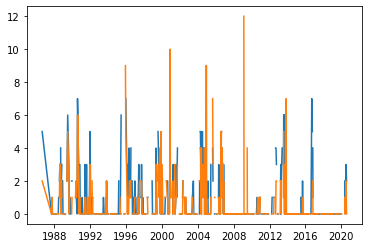

In [12]:
k = 1
plt.plot(c2_25[uids[k]].index, c2_25[uids[k]].px_wet)
plt.plot(c3_30[uids[k]].index, c3_30[uids[k]].px_wet)

## Least-squares error

We can also look at the least-squares error between C2 and C3, for those with overlapping observations. It seems like C3 has a stricter cloud mask than C2, so we should have less observations, but the ones we do have should align.

In [13]:
lses_pc = []
lses_px = []
for uid in uids:
    c2 = c2_25[uid].resample("1D").mean()
    c3 = c3_30[uid].resample("1D").mean()
    lse = np.sqrt(np.mean((c2.pc_wet - c3.pc_wet) ** 2))
    lses_pc.append(lse)
    lse = np.sqrt(np.mean((c2.px_wet - c3.px_wet) ** 2))
    lses_px.append(lse)

In [126]:
lses_px = np.array(lses_px)

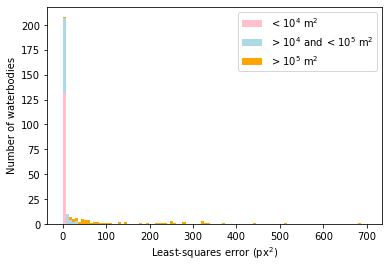

In [129]:
bins = np.linspace(0, 700, 100)
hist = plt.hist([
    lses_px[wbs.area < 1e4],
    lses_px[(wbs.area > 1e4) & (wbs.area < 1e5)],
    lses_px[wbs.area > 1e5],
], bins=bins, color=['pink', 'lightblue', 'orange'], label=['$<10^4$ m$^2$', '$>10^4$ and $<10^5$ m$^2$', '$>10^5$ m$^2$'], histtype='barstacked')
plt.ylabel("Number of waterbodies")
plt.legend();
plt.xlabel("Least-squares error (px$^2$)")
plt.ylabel("Number of waterbodies");

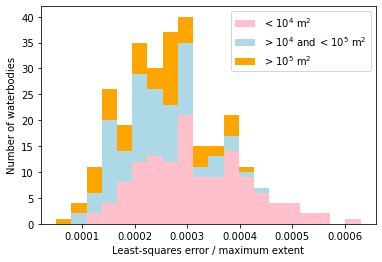

In [133]:
bins = 20
hist = plt.hist([
    (lses_px / wbs.area)[wbs.area < 1e4],
    (lses_px / wbs.area)[(wbs.area > 1e4) & (wbs.area < 1e5)],
    (lses_px / wbs.area)[wbs.area > 1e5],
], bins=bins, color=['pink', 'lightblue', 'orange'], label=['$<10^4$ m$^2$', '$>10^4$ and $<10^5$ m$^2$', '$>10^5$ m$^2$'], histtype='barstacked')
plt.legend()
plt.xlabel("Least-squares error / maximum extent")
plt.ylabel("Number of waterbodies");

In [119]:
lses_pc = np.array(lses_pc)

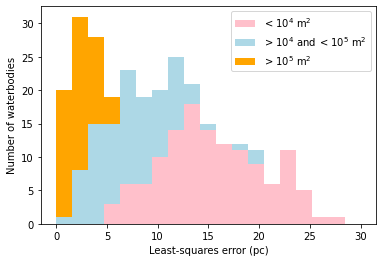

In [125]:
bins = np.linspace(0, 30, 20)
hist = plt.hist([
    lses_pc[wbs.area < 1e4],
    lses_pc[(wbs.area > 1e4) & (wbs.area < 1e5)],
    lses_pc[wbs.area > 1e5],
], bins=bins, color=['pink', 'lightblue', 'orange'], label=['$<10^4$ m$^2$', '$>10^4$ and $<10^5$ m$^2$', '$>10^5$ m$^2$'], histtype='barstacked')
plt.xlabel("Least-squares error (pc)")
plt.ylabel("Number of waterbodies")
plt.legend();

We already know that the percentage is noisier, so it isn't too surprising that the spread of the MSE is higher for percentages than for pixels. Some of the differences are very high, however, and it would be useful to investigate which objects this is the case for.

## Variance vs discrepancy

One possibility is that highly varying waterbodies are different between C2 and C3 purely because they vary so much, and the slight differences in cloud masking (or whatever) throw us off. Let's plot standard deviation against our distance measures.

In [134]:
c2_variance = [np.std(c2_25[u].px_wet) for u in uids]

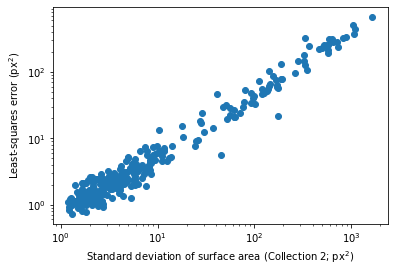

In [136]:
plt.scatter(c2_variance, lses_px)
plt.xlabel("Standard deviation of surface area (Collection 2; px$^2$)")
plt.ylabel("Least-squares error (px$^2$)")
plt.yscale("log")
plt.xscale("log")

In [137]:
scipy.stats.pearsonr(c2_variance, lses_px)

(0.9779911898987794, 1.1978944355045563e-194)

This makes sense! In fact, the LSE is essentially measuring the standard deviation of the surface area (note that they are in the same units). This means that the discrepancy is likely entirely explained through noise.

## Properties of missing or added data

Are the data points that are dropped by C3 particularly wet?

In [25]:
c2_where_c3_missing = []
c3_where_c2_missing = []
for u in uids:
    c2 = c2_25[u]
    c3 = c3_30[u]
    joined = c2.join(c3, lsuffix="_c2", rsuffix="_c3", how="outer")
    missing_c2 = pd.isnull(joined.pc_wet_c2)
    missing_c3 = pd.isnull(joined.pc_wet_c3)
    c2_where_c3_missing.append(
        (joined[missing_c3 & ~missing_c2].pc_wet_c2 - joined.pc_wet_c2.mean()).mean()
    )
    c3_where_c2_missing.append(
        (joined[missing_c2 & ~missing_c3].pc_wet_c3 - joined.pc_wet_c3.mean()).mean()
    )

In [26]:
c2_where_c3_missing = np.array(c2_where_c3_missing)
c2_where_c3_missing = c2_where_c3_missing[~np.isnan(c2_where_c3_missing)]

In [27]:
c3_where_c2_missing = np.array(c3_where_c2_missing)
c3_where_c2_missing = c3_where_c2_missing[~np.isnan(c3_where_c2_missing)]

In [28]:
bins = np.linspace(-10, 10, 100)

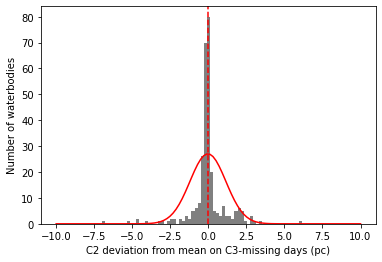

In [29]:
loc_c2c3, scale_c2c3 = distributions.norm.fit(c2_where_c3_missing)
dist_c2c3 = distributions.norm(loc=loc_c2c3, scale=scale_c2c3)
hist = plt.hist(c2_where_c3_missing, bins=bins, color="grey")
plt.plot(bins, dist_c2c3.pdf(bins) * hist[0].max(), c="red")
plt.axvline(np.nanmean(c2_where_c3_missing), c="red", linestyle="--")
plt.xlabel("C2 deviation from mean on C3-missing days (pc)")
plt.ylabel("Number of waterbodies");

C3 missing days tend to have _slightly_ higher surface areas. Is this significant?

In [30]:
scipy.stats.ttest_1samp(c2_where_c3_missing, 0)

Ttest_1sampResult(statistic=-0.4161558243397899, pvalue=0.6776102914636308)

This is _not_ significant.

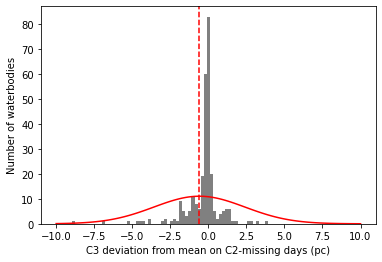

In [31]:
loc_c3c2, scale_c3c2 = distributions.norm.fit(c3_where_c2_missing)
dist_c3c2 = distributions.norm(loc=loc_c3c2, scale=scale_c3c2)
hist = plt.hist(c3_where_c2_missing, bins=bins, color="grey")
plt.plot(bins, dist_c3c2.pdf(bins) * hist[0].max(), c="red")
plt.axvline(np.mean(c3_where_c2_missing), c="red", linestyle="--")
plt.xlabel("C3 deviation from mean on C2-missing days (pc)")
plt.ylabel("Number of waterbodies");

The spread for the deviation on newly-added days in C3 is way higher. The mean is slightly negative, but again, is this significant?

In [32]:
scipy.stats.ttest_1samp(c3_where_c2_missing, 0)

Ttest_1sampResult(statistic=-3.3102715400242952, pvalue=0.0010524569798119224)

This _is_ significant at the 0.2% level. The waterbodies are slightly _drier_ on days where C2 did not record an observation but C3 did.

## Is there a spatial pattern in missing data?

In [63]:
n_valid_c2 = [pd.notnull(c2_25[u].pc_wet).sum() for u in uids]
n_valid_c3 = [pd.notnull(c3_30[u].pc_wet).sum() for u in uids]

Text(0, 0.5, 'Number of observations in C3')

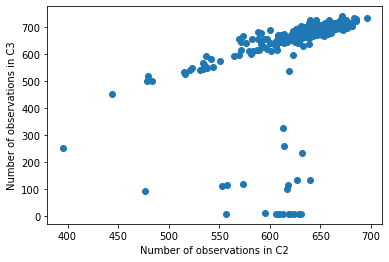

In [64]:
plt.scatter(n_valid_c2, n_valid_c3)
plt.xlabel('Number of observations in C2')
plt.ylabel('Number of observations in C3')

In [35]:
diff = np.array(n_valid_c2) - n_valid_c3

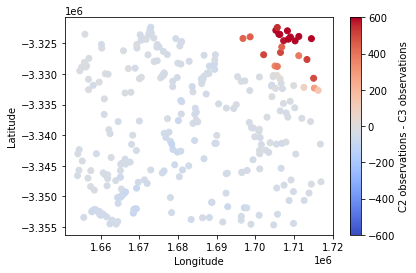

In [143]:
plt.scatter(wbs.centroid.x, wbs.centroid.y, c=diff, vmin=-600, vmax=600, cmap='coolwarm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='C2 observations - C3 observations')

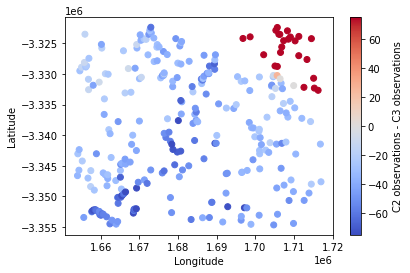

In [146]:
plt.scatter(wbs.centroid.x, wbs.centroid.y, c=diff, vmin=-75, vmax=75, cmap='coolwarm')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='C2 observations - C3 observations')

This particular Collection 3 dataset has less data than Collection 2 in the northeast.

## Are any waterbodies highly deviant?

Some waterbodies have quite high discrepancies between C2 and C3. These are mostly either small objects (so the percentage varies a lot) or large objects (so the pixel count varies a lot). A deviant waterbody therefore is either a small object with large pixel variation or a large object with large percentage variation.

Text(0, 0.5, 'Least-squares error (px$^2$)')

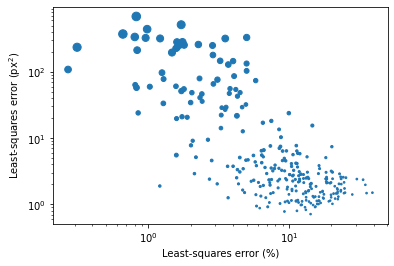

In [53]:
plt.scatter(lses_pc, lses_px, s=np.sqrt(wbs.area / 500))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Least-squares error (%)')
plt.ylabel('Least-squares error (px$^2$)')

All large objects have less than 5% error:

Text(0, 0.5, 'Least-squares error (%)')

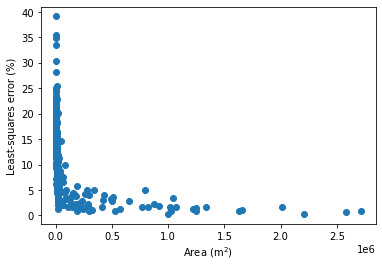

In [56]:
plt.scatter(wbs.area, lses_pc)
plt.xlabel('Area (m$^2$)')
plt.ylabel('Least-squares error (%)')

And area is tighly correlated with least-squares error:

Text(0, 0.5, 'Least-squares error (m$^2$)')

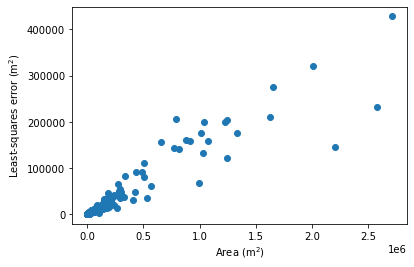

In [62]:
plt.scatter(wbs.area, np.array(lses_px) * 25 ** 2)
plt.xlabel('Area (m$^2$)')
plt.ylabel('Least-squares error (m$^2$)')

In [148]:
scipy.stats.pearsonr(wbs.area, np.array(lses_px) * 25 ** 2)

(0.9452324750363384, 1.2314950155097563e-139)

## Conclusion

Waterbodies in Collection 3 appear slightly drier on average than in Collection 2, which is particularly evident in smaller waterbodies. Everything else seems consistent between the two.